In [1]:
!pip install datasets

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import re


In [2]:
ds = load_dataset("ag_news")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [28]:
label_names = ds["train"].features["label"].names

train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

train_counts = train_df["label"].value_counts().sort_index()
test_counts = test_df["label"].value_counts().sort_index()

df = pd.DataFrame({
    "train": train_counts.values,
    "test": test_counts.values
}, index=[label_names[i] for i in train_counts.index])

print(df)

          train  test
World     30000  1900
Sports    30000  1900
Business  30000  1900
Sci/Tech  30000  1900


Classes are balanced

In [ ]:
df_eda = pd.concat([
    ds["train"].to_pandas(),
    ds["test"].to_pandas()
], ignore_index=True)
df_eda.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
# names for numerical labels
print(ds["train"].features['label'].names)

df_eda["label_name"] = df_eda["label"].apply(lambda x: label_names[x])
df_eda.head(2)

['World', 'Sports', 'Business', 'Sci/Tech']


,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business


In [5]:
df_eda.describe()


,label
count,127600.000000
mean,1.500000
std,1.118038
min,0.000000
25%,0.750000
50%,1.500000
75%,2.250000
max,3.000000


In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        127600 non-null  object
 1   label       127600 non-null  int64 
 2   label_name  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


No null entries in dataset

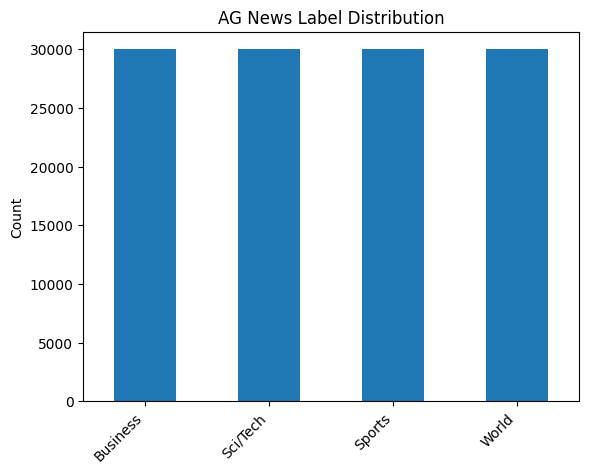

In [7]:
labels = ds["train"]["label"]

label_counts = Counter(labels)
label_series = pd.Series({label_names[i]: c for i, c in label_counts.items()}).sort_values(ascending=False)

label_series.plot(kind="bar")
plt.title("AG News Label Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

Classes are balanced

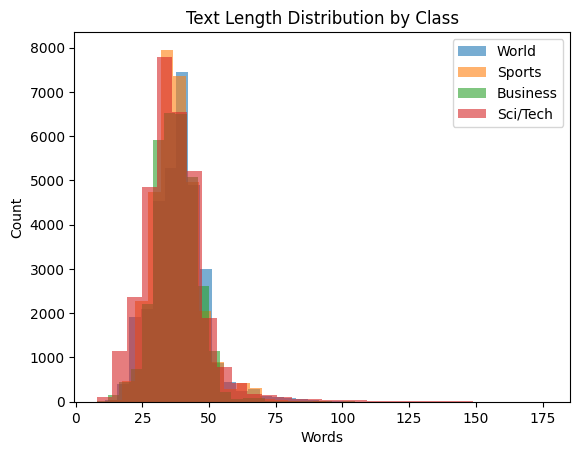

Median text length:
Sci/Tech - 36.0
Business - 37.0
Sports - 37.0
World - 39.0


In [8]:
df_eda["text_length"] = df_eda["text"].str.split().str.len()

for i, label in enumerate(label_names):
    subset = df_eda[df_eda["label"] == i]
    plt.hist(
        subset["text_length"], 
        bins=30, 
        alpha=0.6, 
        label=label
    )

plt.title("Text Length Distribution by Class")
plt.xlabel("Words")
plt.ylabel("Count")
plt.legend()
plt.show()

median_vals = df_eda.groupby("label_name")["text_length"].median().sort_values()

print('Median text length:')
for name, val in median_vals.items():
    print(name,'-',val)

In [9]:
# examples from each class

for i, label in enumerate(label_names):
    example = df_eda[df_eda["label"] == i]["text"].iloc[1]
    print(f"\nLabel: {label}\nExample: {example}")


Label: World
Example: S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Korean police used water cannon in\central Seoul Sunday to disperse at least 7,000 protesters\urging the government to reverse a controversial decision to\send more troops to Iraq.

Label: Sports
Example: Reds Knock Padres Out of Wild-Card Lead (AP) AP - Wily Mo Pena homered twice and drove in four runs, helping the Cincinnati Reds beat the San Diego Padres 11-5 on Saturday night. San Diego was knocked out of a share of the NL wild-card lead with the loss and Chicago's victory over Los Angeles earlier in the day.

Label: Business
Example: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

Label: Sci/Tech
Example: Group to Propose New High-Speed Wireless Format (Reuters) Reut

Feature importance using TF-IDF

In [10]:
vectorise = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorise.fit_transform(df_eda["text"])

feature_names = vectorise.get_feature_names_out()
top_terms = pd.Series(X.toarray().sum(axis=0), index=feature_names).sort_values(ascending=False)
top_terms.head(15)

39           5686.917798
new          3174.300136
ap           3093.297144
reuters      2749.958748
said         2709.361109
quot         1986.476992
gt           1899.853704
lt           1893.770279
year         1796.121430
world        1677.693017
company      1460.613778
oil          1437.143728
monday       1415.665887
wednesday    1380.776153
tuesday      1378.782889
dtype: float64

Clean weekdays/html remnants etc from text

In [ ]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'&[a-z]+;|quot', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\b(ap|reuters|afp)\b', ' ', text)
    text = re.sub(r'\b\d+\b', ' ', text)
    # removing weekdays from text as they as associated with sylistic bias 
    # rather than semantic which could limit model generalisation
    text = re.sub(r'\b(monday|tuesday|wednesday|thursday|friday|saturday|sunday)\b', ' ', text)  # removing weekdays from text as they as associated with sylistic bias rather than semantic meaning
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r"http\S+|www\S+|href|aspx", "", text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_eda["clean_text"] = df_eda['text'].apply(clean_text)

vectorise = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorise.fit_transform(df_eda["clean_text"])

feature_names = vectorise.get_feature_names_out()
top_terms = pd.Series(X.toarray().sum(axis=0), index=feature_names).sort_values(ascending=False)
top_terms.head(15)

new          3296.473371
said         2859.877562
year         1876.068005
world        1735.015805
company      1508.066179
oil          1485.112335
game         1378.399977
microsoft    1355.670325
yesterday    1326.987414
iraq         1314.152504
president    1284.169879
time         1278.459354
million      1257.915728
york         1242.252968
week         1237.456857
dtype: float64

In [12]:
cv = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=10)
bigrams = cv.fit_transform(df_eda["clean_text"])
pd.DataFrame(cv.get_feature_names_out(), columns=["common_bigrams"]).head(10)

,common_bigrams
0,new york
1,oil prices
2,president bush
3,prime minister
4,red sox
5,san francisco
6,sports network
7,stocks quickinfo
8,target stocks
9,united states


## Modelling

In [13]:
#clean original dataset

X_train = [clean_text(t) for t in ds['train']['text']]
y_train = ds['train']['label']

X_test = [clean_text(t) for t in ds['test']['text']]
y_test = ds['test']['label']

In [14]:

vectoriser = TfidfVectorizer(
    stop_words='english',
    max_features=5000,  
    ngram_range=(1,2)   
)

X_train_tfidf = vectoriser.fit_transform(X_train)
X_test_tfidf = vectoriser.transform(X_test)

In [15]:
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])


pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))),
    ("clf", MultinomialNB())
])


In [17]:

models = {
    "Logistic Regression (TF-IDF)": pipe_lr,
    "Naive Bayes (TF-IDF)": pipe_nb  
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name:25s} | Acc: {acc:.3f} | F1: {f1:.3f}")
    print(classification_report(y_test, y_pred, target_names=label_names),'\n')
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "y_pred": y_pred,
        "model_obj": model
    })


Logistic Regression (TF-IDF) | Acc: 0.903 | F1: 0.903
              precision    recall  f1-score   support

       World       0.92      0.89      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.86      0.87      0.87      1900
    Sci/Tech       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600
 

Naive Bayes (TF-IDF)      | Acc: 0.892 | F1: 0.892
              precision    recall  f1-score   support

       World       0.90      0.89      0.90      1900
      Sports       0.94      0.97      0.96      1900
    Business       0.86      0.84      0.85      1900
    Sci/Tech       0.86      0.87      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600
 



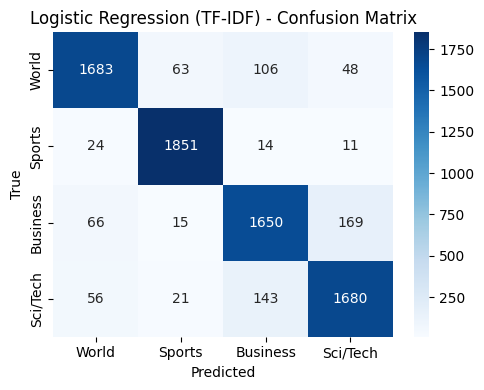

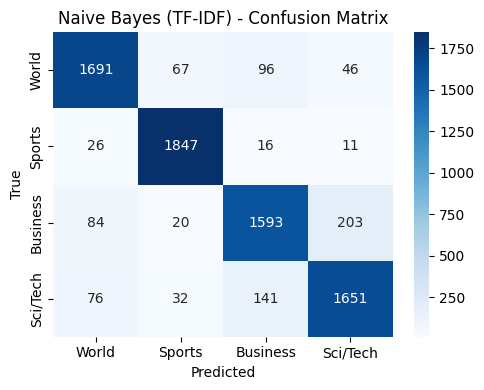

In [22]:
from sklearn.metrics import confusion_matrix

for res in results:
    name = res["Model"]
    model = res["model_obj"]
    y_pred = res["y_pred"]

    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

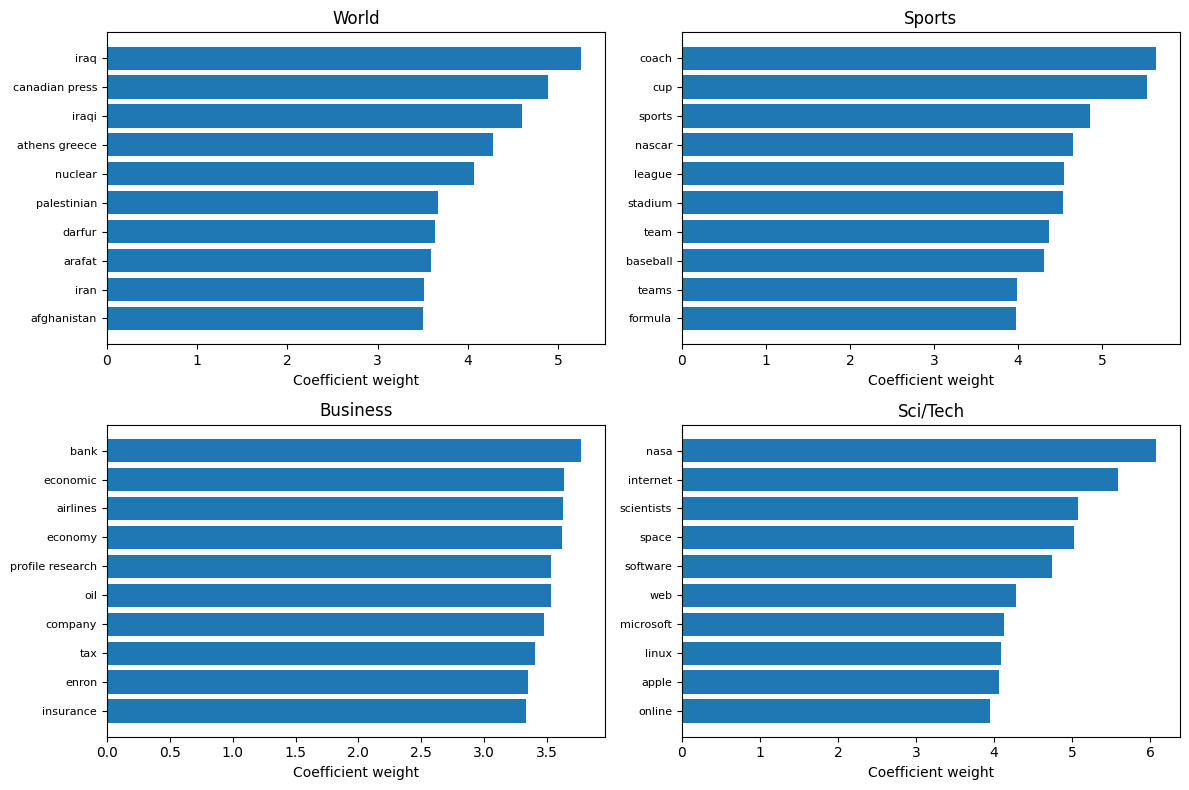

In [ ]:
lr = [r["model_obj"] for r in results if "Logistic Regression" in r["Model"]][0]
clf, vect = lr.named_steps["clf"], lr.named_steps["tfidf"]
coefs, features = clf.coef_, np.array(vect.get_feature_names_out())

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes[:len(clf.classes_)]):
    idx = np.argsort(coefs[i])[-10:]
    ax.barh(features[idx], coefs[i][idx])
    ax.set_title(label_names[i])
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xlabel("Coefficient weight")


plt.tight_layout()
plt.show()


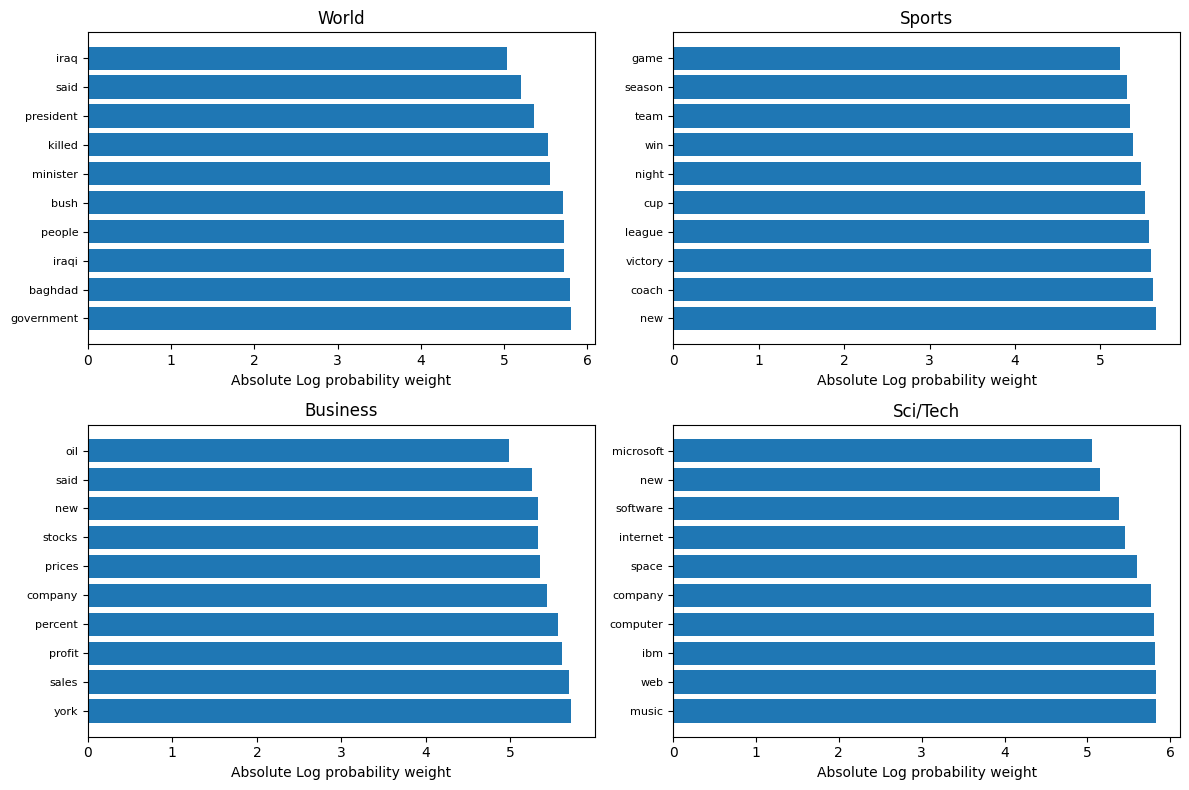

In [20]:
nb = [r["model_obj"] for r in results if "Naive Bayes" in r["Model"]][0]
clf, vect = nb.named_steps["clf"], nb.named_steps["tfidf"]
log_probs, features = clf.feature_log_prob_, np.array(vect.get_feature_names_out())

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes[:len(clf.classes_)]):
    idx = np.argsort(log_probs[i])[-10:]
    ax.barh(features[idx], abs(log_probs[i][idx]))
    ax.set_title(label_names[i])
    ax.set_xlabel("Absolute Log probability weight")
    ax.tick_params(axis="y", labelsize=8)

for ax in axes[len(clf.classes_):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


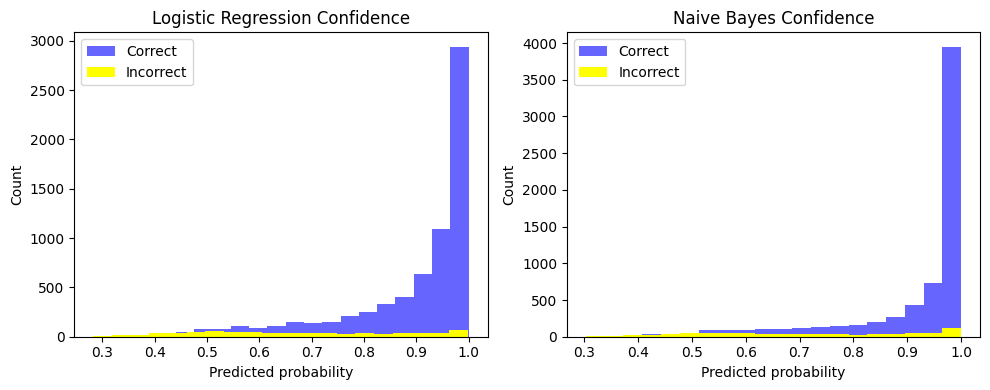

,Model,Mean Conf (Correct),Mean Conf (Incorrect)
0,Logistic Regression,0.891987,0.677794
1,Naive Bayes,0.913605,0.706578


In [ ]:
lr_probs = models["Logistic Regression (TF-IDF)"].predict_proba(X_test)
lr_conf = lr_probs.max(axis=1)
lr_correct = (models["Logistic Regression (TF-IDF)"].predict(X_test) == y_test)

nb_probs = models["Naive Bayes (TF-IDF)"].predict_proba(X_test)
nb_conf = nb_probs.max(axis=1)
nb_correct = (models["Naive Bayes (TF-IDF)"].predict(X_test) == y_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(lr_conf[lr_correct], bins=20, alpha=0.6, label="Correct", color="blue")
axes[0].hist(lr_conf[~lr_correct], bins=20, alpha=1, label="Incorrect", color="yellow")
axes[0].set_title("Logistic Regression Confidence")
axes[0].set_xlabel("Predicted probability")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(nb_conf[nb_correct], bins=20, alpha=0.6, label="Correct", color="blue")
axes[1].hist(nb_conf[~nb_correct], bins=20, alpha=1, label="Incorrect", color="yellow")
axes[1].set_title("Naive Bayes Confidence")
axes[1].set_xlabel("Predicted probability")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()

conf_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes"],
    "Mean Conf (Correct)": [lr_conf[lr_correct].mean(), nb_conf[nb_correct].mean()],
    "Mean Conf (Incorrect)": [lr_conf[~lr_correct].mean(), nb_conf[~nb_correct].mean()]
})
display(conf_summary)


LR shows better calibration with a lower mean confidence for incorrect predictions.

In [ ]:
for i, label in enumerate(label_names):
    lr_top = set(features[np.argsort(coefs[i])[-20:]])
    nb_top = set(features[np.argsort(log_probs[i])[-20:]])

    overlap = lr_top & nb_top
    lr_only = lr_top - nb_top
    nb_only = nb_top - lr_top

    print(f"\n{label}")
    print("Common:", ", ".join(list(overlap)[:5]))
    print("LR-only:", ", ".join(list(lr_only)[:5]))
    print("NB-only:", ", ".join(list(nb_only)[:5]))



World
Common: leader, palestinian, troops, military, president
LR-only: arafat, canadian press, hostage, terrorism, sudan
NB-only: government, prime minister, prime, bush, new

Sports
Common: cup, coach, sports, team, league
LR-only: quarterback, nascar, champion, formula, nhl
NB-only: football, win, time, lead, world

Business
Common: corp, dollar, company, oil
LR-only: update, investment, airlines, hollinger, profile research
NB-only: billion, sales, oil prices, percent, said

Sci/Tech
Common: computer, web, ibm, apple, software
LR-only: researchers, evolution, arctic, study, nasa
NB-only: music, google, said, new, search


In [19]:


lr_pred = models["Logistic Regression (TF-IDF)"].predict(X_test)
nb_pred = models["Naive Bayes (TF-IDF)"].predict(X_test)

lr_correct = (lr_pred == y_test).astype(int)
nb_correct = (nb_pred == y_test).astype(int)

corr = np.corrcoef(1 - lr_correct, 1 - nb_correct)[0, 1]

print(f"Error correlation: {corr:.2f}")


Error correlation: 0.76


The high correlation in error between the models suggest that improving model diversity (eg: embeddings/feature engineering/parameter adjustment ie: changing of n_gram ranges) would lead to more effective improvments than using an LR + NB ensemble.

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", 
                     model="facebook/bart-large-mnli")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.
The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Sci/Tech


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Business


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Sci/Tech


The `multi_class` argument has been deprecated and renamed to `multi_label`. `multi_class` will be removed in a future version of Transformers.


Business
Business


In [ ]:
def classify_flan(text):
    labels = ["World", "Sports", "Business", "Sci/Tech"]
    result = classifier(text[:512], candidate_labels=labels, multi_label=False)
    return result["labels"][0]

# Get Naive Bayes predictions from your results object
nb = [r["model_obj"] for r in results if "Naive Bayes" in r["Model"]][0]
nb_preds = nb.predict(X_test)

# Run on misclassified samples (by LR)
for i, (t, y_true, y_lr) in enumerate(zip(texts, true_labels, lr_preds)):
    y_nb = nb_preds[sample_idx[i]]
    print(f"\nText: {t}")
    print(f"True: {label_names[y_true]} | LR: {label_names[y_lr]} | NB: {label_names[y_nb]}")
    bart_pred = classify_flan(t)
    print(f"BART: {bart_pred}")


Text: study wrecks jump days after terrorism fatal traffic accidents increase sharply in israel on the third day after a terrorist attack and researchers are searching for an explanation why
True: Sci/Tech | LR: World | NB: World
BART Zero-Shot Prediction → Sci/Tech

Text: oracle chairman says can close gap with sap report oracle corp can close the gap with sap the world s biggest software company after buying us rival peoplesoft oracle s chairman jeff henley said in an interview published on
True: Business | LR: Sci/Tech | NB: Business
BART Zero-Shot Prediction → Business

Text: cingular to cut about jobs cingular wireless will cut about jobs or percent of its work force to cut costs as it integrates recently purchased at t wireless the company said on
True: Sci/Tech | LR: Business | NB: Business
BART Zero-Shot Prediction → Sci/Tech

Text: alaska s summer tourism pegged at million visitors the number of summer visitors to alaska rose from the year before prompting the president of th

In all but one case the BART model captures true labels missed using LR or NB.